# Физичко дистанцирање

In [1]:
import networkx
import epyc
import epydemic
import pandas
import mpmath
import numpy

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=1.75)

In [2]:
def distanced_graph(N, clusterSizeDistribution, contactDistribution, clusterContactDistribution):
    # build the initial graph
    g = networkx.Graph()
    
    # build the clusters, each being a complete
    # graph K_s of size s, labelled uniquely 
    # within the overall graph
    rng = np.random.default_rng()
    n = 0
    cid = 1
    clusters = []
    while n < N:
        # build the cluster's graph with a random size
        s = clusterSizeDistribution()
        K_s = networkx.complete_graph(s)
        
        # relabel the cluster graph so all nodes in the final
        # social distence graph have unique integer labels
        networkx.relabel_nodes(K_s, lambda l: n + l,
                               copy=False)
        
        # add to the graph and list of clusters
        # label edges with the cluster they belong to
        # (numbered from 1) and the size of the cluster
        g.add_nodes_from(K_s.nodes,
                         cluster=cid, cluster_size=s)
        g.add_edges_from(K_s.edges,
                         cluster=cid, cluster_size=s)
        clusters.append(K_s)
        n += s
        cid += 1
        
    # draw the number of contact nodes per cluster from
    # from the distribution
    contacts = []
    for c in clusters:
        s = c.order()
        d = contactDistribution(s)
        contacts.append(d)
        
    # decide on the arity of each contact node
    stubs = []
    for i in range(len(clusters)):
        c = clusters[i]
        # first i node labels (since all nodes are
        # identical in K_s) 
        ls = list(c.nodes())[:contacts[i]]   
        for l in ls:
            # draw the number of contacts for this node
            e = clusterContactDistribution(n)
            
            # append e copies of the node label to
            # the list of stubs
            stubs.extend([l] * e)
    
    # if number of stubs isn't even, add one to a
    # randomly-chosen node (don't favour
    # already-high-degree nodes
    if len(stubs) % 2 > 0:
        us = list(set(stubs))                
        j = rng.integers(len(us))
        stubs.append(us[j])
        
    # shuffle the stubs until there are no edge
    # pair with the same endpoints
    rng.shuffle(stubs) # may leave loops
    while True:
        # look for pairtings of stubs and others
        # within the same cluster, and break them
        # randomly (without changing the degree
        # distribution)
        swaps = 0
        for i in range(0, len(stubs), 2):
            if g.nodes[stubs[i]]['cluster'] == g.nodes[stubs[i + 1]]['cluster']:
                # self loop, swap with another
                # randomly-chosen stub
                j = rng.integers(len(stubs))
                t = stubs[i + 1]
                stubs[i + 1] = stubs[j]
                stubs[j] = t
                
                swaps += 1
        if swaps == 0:
            # no swaps, we're finished
            break

    # connect the nodes by pulling pairs of stubs
    # and creating an edge between them
    for i in range(0, len(stubs), 2):
        # label inter-bubble edges as cluster 0 of size 0
        g.add_edge(stubs[i], stubs[i + 1],
                   cluster=0, cluster_size=0)
    
    # return the graph and list of cluster sizes
    return (g, list(map(lambda h: h.order(), clusters)))

In [3]:
def averageFamily():
    rng = np.random.default_rng()
    return max(int(rng.normal(4.5, 2)), 1)

In [4]:
def coupleOfContacts(s):
    rng = np.random.default_rng()
    return max(int(rng.normal(min(s / 2, 2), 1)), 1)

In [5]:
def expInterBubble(n):
    rng = np.random.default_rng()
    return max(int(rng.exponential(10.0)), 1)

In [6]:
N = 1000

In [7]:
(g, clusters) = distanced_graph(N, averageFamily, coupleOfContacts, expInterBubble)

In [8]:
print('Mean family size of {s:.2f} (range {minf}-{maxf})'.format(s=np.mean(clusters), minf=min(clusters), maxf=max(clusters)))
print('Most connected individual has {k} contacts'.format(k=max(dict(g.degree()).values())))

Mean family size of 4.07 (range 1-10)
Most connected individual has 63 contacts


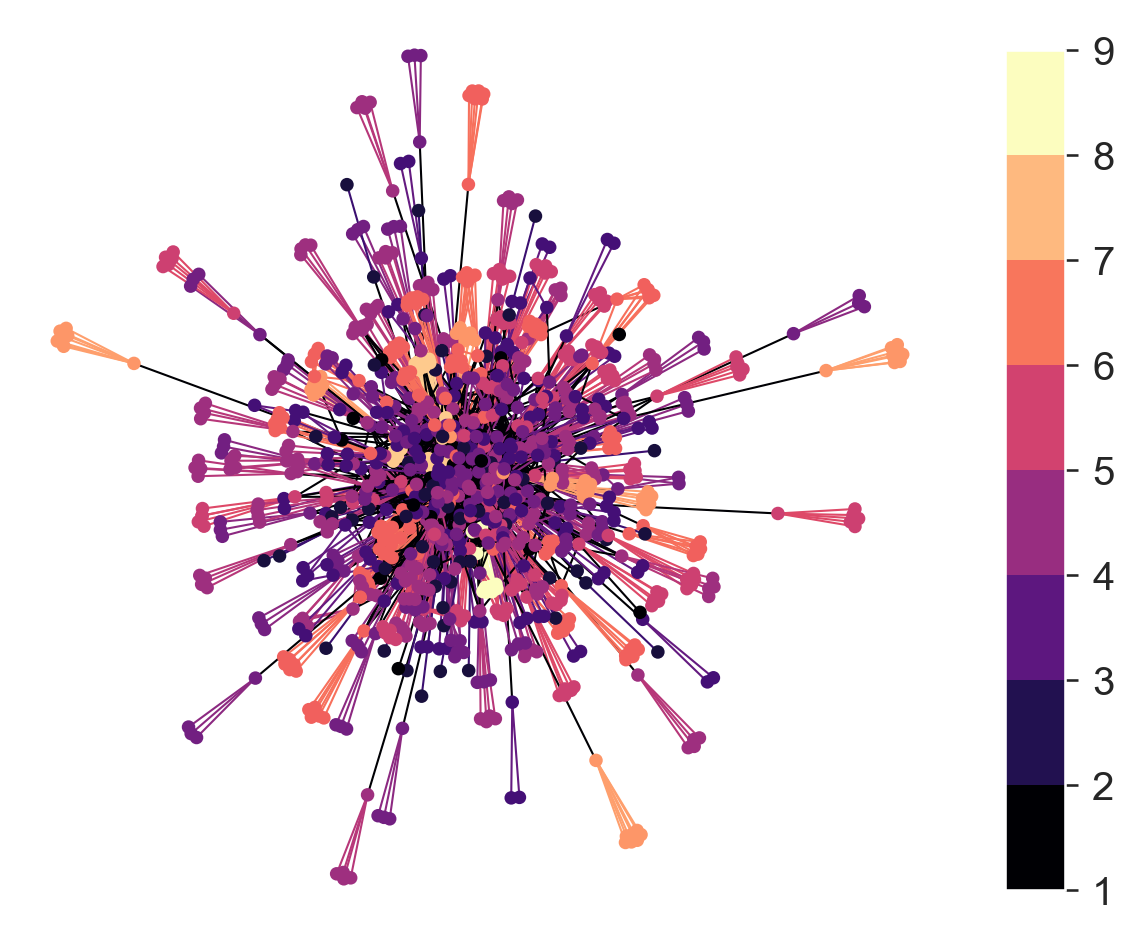

In [9]:
def draw_distanced(g, cmap=None,
                   color='cluster_size',
                   ax=None):
    # fill in defaults
    if cmap is None:
        cmap = plt.get_cmap('viridis')
    if ax is None:
        ax = plt.gca()
    
    # work out the colours 
    ncs = list(map(lambda n: g.nodes[n][color],
                   g.nodes()))
    ecs = list(map(lambda e: g.edges[e][color],
                   g.edges()))
               
    # draw with spring layout, which seems to
    # give good results
    networkx.draw_spring(g,
                         ax=ax,
                         with_labels=False,
                         node_size=30,
                         node_color=ncs,
                         edge_color=ecs,
                         cmap=cmap,
                         edge_cmap=cmap)

fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# draw network
cmap = plt.get_cmap('magma')
draw_distanced(g, cmap=cmap)

# add key (see https://matplotlib.org/examples/api/colorbar_only.html)
bounds = list(range(min(clusters), max(clusters)))
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
ax1 = fig.add_axes([0.95, 0.15, 0.05, 0.7])
cb2 = matplotlib.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    boundaries=bounds,
                                    ticks=bounds,
                                    spacing='proportional',
                                    orientation='vertical')

plt.savefig('physical-distancing.png')
_ = plt.show()

In [10]:
# from https://nbviewer.jupyter.org/gist/minrk/4470122
def pxlocal(line, cell):
    ip = get_ipython()
    ip.run_cell_magic("px", line, cell)
    ip.run_cell(cell)
get_ipython().register_magic_function(pxlocal, "cell")

In [11]:
class MonitoredSIR(epydemic.SIR, epydemic.Monitor):
 
    def __init__(self):
        super(MonitoredSIR, self).__init__()
        
    def build(self, params):
        '''Build the observation process.
        
        :param params: the experimental parameters'''
        super(MonitoredSIR, self).build(params)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)

In [12]:
class PhyDistNetworkDynamics(epydemic.StochasticDynamics):
    
    # Experimental parameters
    N = 'N'
    BUBBLE_MEAN = 'bubbleMean'
    BUBBLE_STDDEV = 'bubbleStddev'
    INTERBUBBLE_EXP= 'interBubbleExp'
    
    def __init__(self, p):
        super(PhyDistNetworkDynamics, self).__init__(p)
        
    def bubbleSize(self):
        rng = np.random.default_rng()
        return max(int(rng.normal(self._bubbleMean,
                                  self._bubbleStddev)), 1)

    def contacts(self, s):
        rng = np.random.default_rng()
        return max(int(rng.normal(min(s / 2, 2), 1)), 1)    

    def interBubble(self):
        rng = np.random.default_rng()
        return max(int(rng.exponential(self._interBubbleExponent)), 1)
        
    def distanced(self, N):
        g = networkx.Graph()
    
        rng = np.random.default_rng()
        n = 0
        cid = 1
        clusters = []
        while n < N:
            s = self.bubbleSize()
            K_s = networkx.complete_graph(s)
            
            networkx.relabel_nodes(K_s,
                                   lambda l: n + l, copy=False)
            g.add_nodes_from(K_s.nodes,
                             cluster=cid, cluster_size=s)
            g.add_edges_from(K_s.edges,
                             cluster=cid, cluster_size=s)
            clusters.append(K_s)
            n += s
            cid += 1
        
        contacts = []
        for c in clusters:
            s = c.order()
            d = self.contacts(s)
            contacts.append(d)
            
        stubs = []
        for i in range(len(clusters)):
            c = clusters[i]
            ls = list(c.nodes())[:contacts[i]] 
            for l in ls:
                e = self.interBubble()
                stubs.extend([l] * e)
        if len(stubs) % 2 > 0:
            us = list(set(stubs))
            j = rng.integers(len(us))
            stubs.append(us[j])
        
        rng.shuffle(stubs)
        while True:
            swaps = 0
            for i in range(0, len(stubs), 2):
                if g.nodes[stubs[i]]['cluster'] == g.nodes[stubs[i + 1]]['cluster']:
                    j = rng.integers(len(stubs))
                    t = stubs[i + 1]
                    stubs[i + 1] = stubs[j]
                    stubs[j] = t
                    swaps += 1
            if swaps == 0:
                break

        for i in range(0, len(stubs), 2):
            g.add_edge(stubs[i], stubs[i + 1],
                       cluster=0, cluster_size=0)

        return g

    def configure(self, params):
        super(PhyDistNetworkDynamics, self).configure(params)
        
        N = params[self.N]
        self._bubbleMean = params[self.BUBBLE_MEAN]
        self._bubbleStddev = params[self.BUBBLE_STDDEV]
        self._interBubbleExponent = params[self.INTERBUBBLE_EXP]
        g = self.distanced(N)
        self.setNetworkGenerator(g)

In [13]:
# network size
N = 10000

# simulation time
T = 5000

# disease parameters
pInfected = 0.01
pInfect = 0.0003
pRemove = 0.002

In [14]:
# experimental parameters common to both experiments
params = dict()
params[PhyDistNetworkDynamics.N] = 10000
params[PhyDistNetworkDynamics.BUBBLE_MEAN] = 4.5
params[PhyDistNetworkDynamics.BUBBLE_STDDEV] = 2.0
params[PhyDistNetworkDynamics.INTERBUBBLE_EXP] = 10.0
params[epydemic.SIR.P_INFECTED] = pInfected
params[epydemic.SIR.P_INFECT] = pInfect
params[epydemic.SIR.P_REMOVE] = pRemove
params[epydemic.Monitor.DELTA] = T / 50

# create model and experiment over distance network
m = MonitoredSIR()
m.setMaximumTime(T)
e = PhyDistNetworkDynamics(m)

rc = e.set(params).run()

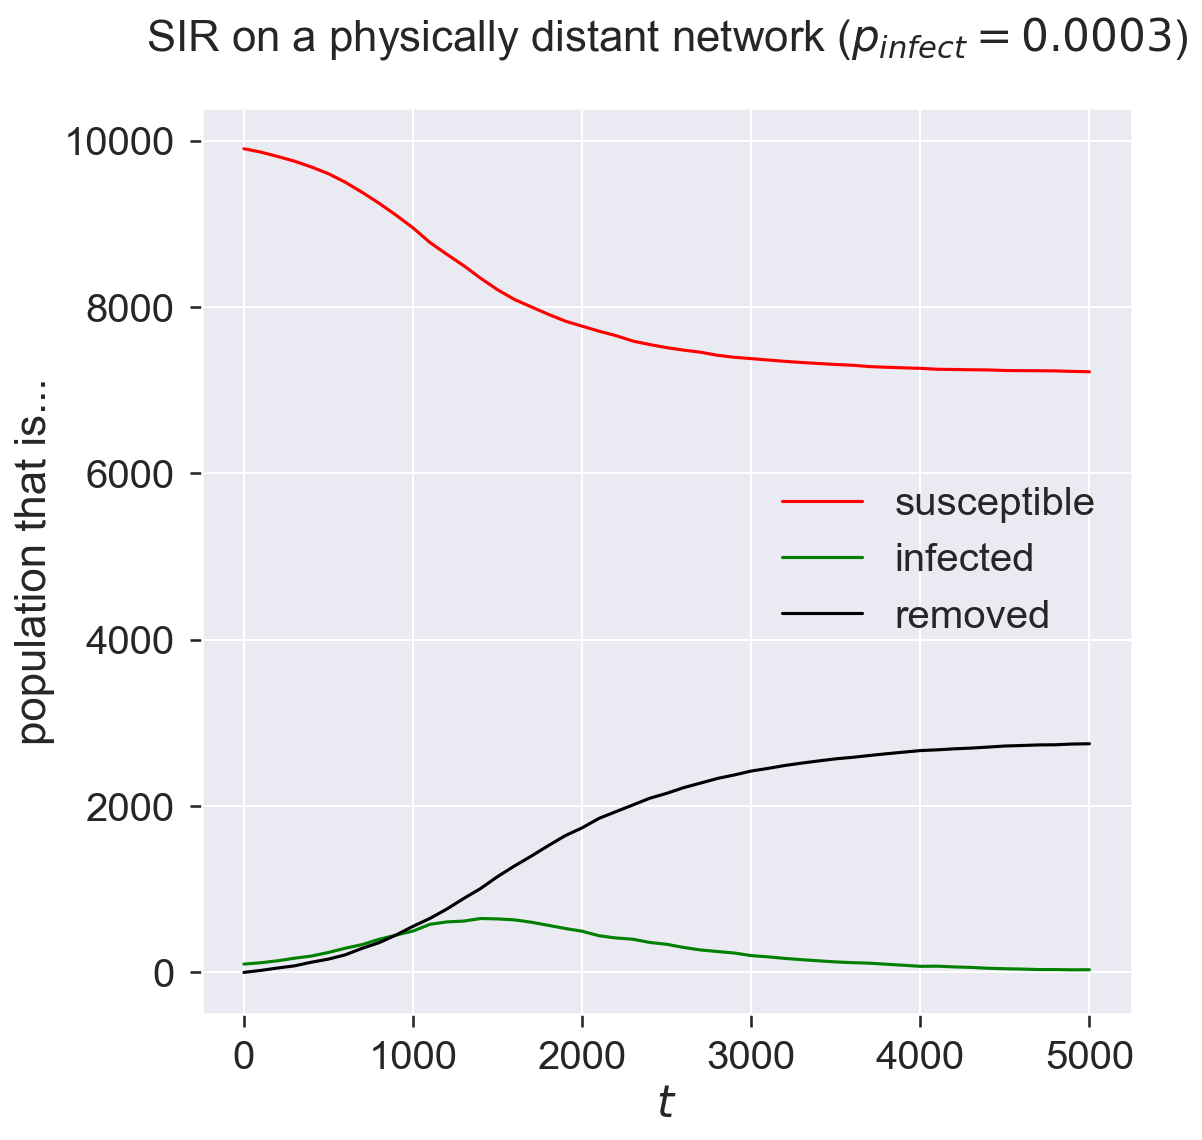

In [16]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

timeseries = rc[epyc.Experiment.RESULTS][epydemic.Monitor.TIMESERIES]
tss = timeseries[epydemic.Monitor.OBSERVATIONS]
sss = timeseries[epydemic.SIR.SUSCEPTIBLE]
iss = timeseries[epydemic.SIR.INFECTED]
rss = timeseries[epydemic.SIR.REMOVED]
ax.plot(tss, sss, 'r-', label='susceptible')
ax.plot(tss, iss, 'g-', label='infected')
ax.plot(tss, rss, 'k-', label='removed')
ax.set_xlabel('$t$')
ax.set_ylabel('population that is...')
ax.legend(loc='center right')

# fine-time the figure
ax.set_title('SIR on a physically distant network ($p_{\mathit{infect}} = ' + '{p}$)'.format(p=pInfect), y=1.05)

_ = plt.show()